In [209]:
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, r2_score
import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem.porter import *
# nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer

In [210]:
def minmax(data, col):
    new_data = data
    max_num = np.max(new_data[:,col])
    min_num = np.min(new_data[:,col])

    for i in range(new_data.shape[0]):
        new_data[i][col] = (new_data[i][col] - min_num) / (max_num - min_num)
    
    return new_data

In [211]:
def makeData(n_samples=93240,n_features=11,dataPath="News_Final.csv"):
    data = pd.read_csv(dataPath)
    data["PublishDate"] = pd.to_datetime(data["PublishDate"], format="%Y-%m-%d %H:%M:%S")
    data['PublishDate'] = data['PublishDate'].apply(lambda x: time.mktime(x.timetuple()))
    data = data.to_numpy()
    
    labels = data[:n_samples,-3:]
    X = data[:n_samples,:-3]
    
    # omitting rows with no usable labels
    bool_matrix = np.any(labels != 0, axis=1)
    labels = labels[bool_matrix]
    X = X[bool_matrix]
    
    bool_matrix = labels[:, 1] != -1
    labels = labels[bool_matrix]
    X = X[bool_matrix]


    ### changing the lables 
    minmax(labels,0)
    minmax(labels,1)
    minmax(labels,2)
    minmax(X,5)

    Y_new = np.zeros(labels.shape[0])
    for i in range(labels.shape[0]):
        if labels[i][0] == -1 and labels[i][1] == -1 and labels[i][2] == -1:
            Y_new[i] = -1

        if labels[i][0] >= labels[i][1] and labels[i][0] >= labels[i][1]:
            Y_new[i] = 0
        elif labels[i][1] >= labels[i][0] and labels[i][1] >= labels[i][2]:
            Y_new[i] = 1
        elif labels[i][2] >= labels[i][1] and labels[i][2] >= labels[i][0]:
            Y_new[i] = 2

    labels = Y_new
    ###
    
    
    return X,labels

In [212]:
def splitData(X, labels, test_size, seed):
    np.random.seed(seed)
    
    indices = range(X.shape[0])
    train_indices = np.random.choice(indices,size = int(len(indices) * (1-test_size)),replace=False)
    test_indices = np.setdiff1d(indices,train_indices)
    
    X_train = X[train_indices]
    X_test = X[test_indices]  
    
    y_train = labels[train_indices]
    y_test = labels[test_indices]
    
    return X_train,X_test,y_train,y_test

In [213]:
from pandas.core.internals.blocks import final
class NewsData(object):
    def __init__(self):
        self.X, self.labels = makeData(5000)
        self.X_train, self.X_test, self.y_train, self.y_test = splitData(self.X,self.labels, 0.2, 2023)
        self.encoder = OneHotEncoder()
        self.vectorizer = TfidfVectorizer()
        self.tfidf = None
        self.corpus = []
        
    def OneHotEncodeTrain(self, index):
        col = np.array(self.X_train[:,index]).reshape(-1, 1)
        self.encoder.fit(col)
        one_hot_data = self.encoder.transform(col).toarray()
        for i in range(self.X_train.shape[0]):
            self.X_train[i][index] = list(one_hot_data[i])
            
    def OneHotEncodeTest(self, index):
        col = np.array(self.X_test[:,index]).reshape(-1, 1)
        self.encoder.fit(col)
        one_hot_data = self.encoder.transform(col).toarray()
        for i in range(self.X_test.shape[0]):
            self.X_test[i][index] = list(one_hot_data[i])
    
    def getCorpus(self, index):
        col = np.array(self.X_train[:,index]).reshape(-1, 1)
        col = [str(x) for x in col]

        row_strings = [''.join(row) for row in col]
        final_string = ''.join(row_strings)

        tokens = word_tokenize(final_string)

        stemmer = PorterStemmer()
        stemmed_tokens = [stemmer.stem(token) for token in tokens]

        final_string = np.unique(stemmed_tokens)

        self.corpus.append(final_string.tolist())

    def combineCorpus(self):
        i = 1
        while i < len(self.corpus):
            for x in self.corpus[i]:
                self.corpus[0].append(str(x))
            i+=1
        self.corpus = self.corpus[0]
        self.corpus = np.unique(self.corpus).tolist()
        self.corpus = pd.DataFrame(self.corpus, columns=['words'])

    def vectorizeTrain(self, index):
        if self.tfidf is None:
            self.tfidf = self.vectorizer.fit_transform(self.corpus['words'].values.astype('U'))
        for i in range(self.X_train.shape[0]):
            if type(self.X_train[i][index]) != type('str'):
                self.X_train[i][index] = ""
            self.X_train[i][index] = (self.vectorizer.transform([self.X_train[i][index]]))
    
    def vectorizeTest(self, index):
        if self.tfidf is None:
            self.tfidf = self.vectorizer.fit_transform(self.corpus['words'].values.astype('U'))
        for i in range(self.X_test.shape[0]):
            if type(self.X_test[i][index]) != type('str'):
                self.X_test[i][index] = ""
            self.X_test[i][index] = (self.vectorizer.transform([self.X_test[i][index]]))

        return self.tfidf.toarray()
    

    def makeCorpus(self, col_num):
        
        col_train = self.X_train[:, col_num]
        col_test = self.X_test[:, col_num]

        
        stemmer = PorterStemmer()
        for col in [col_train, col_test]:
            for sentence in col:
                words = word_tokenize(sentence.lower())
                stemmed_words = [stemmer.stem(word) for word in words]
                self.corpus.extend(stemmed_words)

        self.corpus = list(set(self.corpus))

    def get_top_words(self, numwords = 100):
        vectorizer = TfidfVectorizer()
        vectorizer.fit_transform([' '.join(self.corpus)])

        feature_names = list(vectorizer.vocabulary_.keys())
        tfidf_scores = vectorizer.transform([' '.join(self.corpus)])


        top_keywords_idx = tfidf_scores.toarray()[0].argsort()[::-1][:numwords]
        top_keywords = [feature_names[i] for i in top_keywords_idx]

        return top_keywords
    
    def count_top_words(self):

        top_keywords = self.get_top_words()

        count_train = np.zeros((self.X_train.shape[0], len(top_keywords)))
        count_test = np.zeros((self.X_test.shape[0], len(top_keywords)))

        for i, keyword in enumerate(top_keywords):


            for j, sentence in enumerate(self.X_train[:, 1]):
                words = word_tokenize(sentence.lower())
                stemmed_words = [PorterStemmer().stem(word) for word in words]
                count_train[j][i] = stemmed_words.count(keyword)


            for j, sentence in enumerate(self.X_train[:, 2]):
                words = word_tokenize(sentence.lower())
                stemmed_words = [PorterStemmer().stem(word) for word in words]
                count_train[j][i] += stemmed_words.count(keyword)


            for j, sentence in enumerate(self.X_test[:, 1]):
                words = word_tokenize(sentence.lower())
                stemmed_words = [PorterStemmer().stem(word) for word in words]
                count_test[j][i] += stemmed_words.count(keyword)

            
            for j, sentence in enumerate(self.X_test[:, 2]):
                words = word_tokenize(sentence.lower())
                stemmed_words = [PorterStemmer().stem(word) for word in words]
                count_test[j][i] += stemmed_words.count(keyword)

        self.X_train = np.concatenate((self.X_train, count_train), axis=1)
        self.X_test = np.concatenate((self.X_test, count_test), axis=1)

    

In [214]:
newsData = NewsData()
newsData.OneHotEncodeTrain(3)
newsData.OneHotEncodeTrain(4)

print("1")
newsData.OneHotEncodeTest(3)
newsData.OneHotEncodeTest(4)
print("2")
newsData.makeCorpus(1)
newsData.makeCorpus(2)
newsData.get_top_words(10)
newsData.count_top_words()
newsData.X_train = np.delete(newsData.X_train, 1, axis=1)
newsData.X_train = np.delete(newsData.X_train, 1, axis=1)
# np.concatenate((newsData.X_train, newsData.X_train[]), axis=1)
newsData.X_train = np.delete(newsData.X_train, 1, axis=1)
newsData.X_train = np.delete(newsData.X_train, 1, axis=1)
newsData.X_test = np.delete(newsData.X_test, 1, axis=1)
newsData.X_test = np.delete(newsData.X_test, 1, axis=1)
newsData.X_test = np.delete(newsData.X_test, 1, axis=1)
newsData.X_test = np.delete(newsData.X_test, 1, axis=1)
# newsData.combineCorpus()
# print("3")
# newsData.vectorizeTrain(1)
# newsData.vectorizeTrain(2)
# print("4")
# newsData.vectorizeTest(1)
# newsData.vectorizeTest(2)

1
2


In [215]:
for i in newsData.X_train[0]:

    print(type(i))

# print(newsData.X_test[0][2])

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

In [216]:
for i in newsData.X_train[1]:

    print(i)

1699.0
0.372209005124491
0.0729166666666665
-0.0913061090812413
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


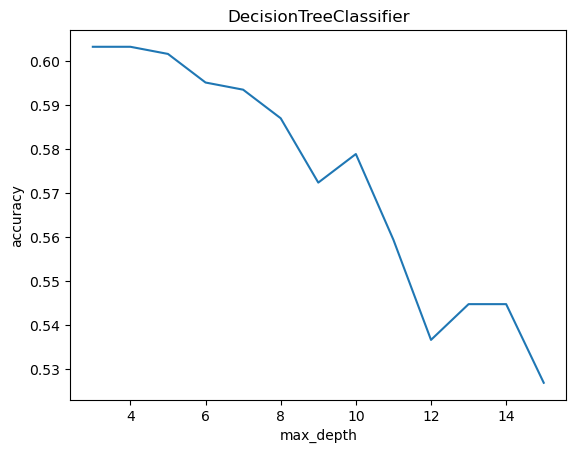

In [229]:


dtc_acc = []
dtc_preds = []
depth_nums = [3,4,5,6,7,8,9,10,11,12,13,14,15]
for i in depth_nums:
    DTC = DecisionTreeClassifier(max_depth= i)
    DTC.fit(newsData.X_train[:, 1:], newsData.y_train)
    dtc_pred = DTC.predict(newsData.X_test[:, 1:])
    dtc_acc.append(accuracy_score(newsData.y_test, dtc_pred))


fig, ax = plt.subplots()
ax.plot(depth_nums, dtc_acc)
ax.set_xlabel('max_depth')
ax.set_ylabel('accuracy')
ax.set_title('DecisionTreeClassifier')
plt.show()


DTC = DecisionTreeClassifier(max_depth= 3)
DTC.fit(newsData.X_train[:, 1:], newsData.y_train)
dtc_pred = DTC.predict(newsData.X_test[:, 1:])

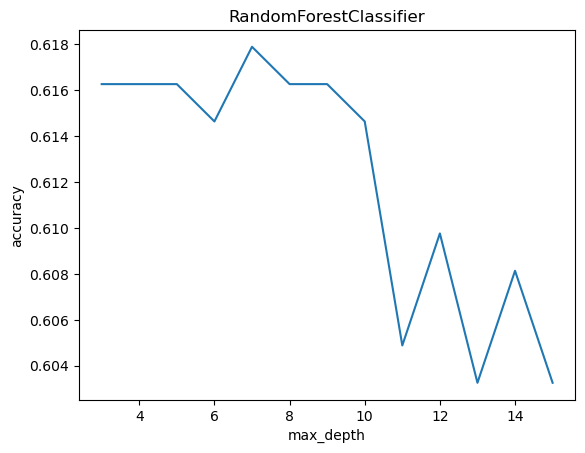

In [234]:

rf_acc = []
for i in depth_nums:
    RF = RandomForestClassifier(n_estimators=100, max_depth = i)
    RF.fit(newsData.X_train[:, 1:], newsData.y_train)
    rf_pred = RF.predict(newsData.X_test[:, 1:])
    rf_acc.append(accuracy_score(newsData.y_test, rf_pred))

fig, ax = plt.subplots()
ax.plot(depth_nums, rf_acc)
ax.set_xlabel('max_depth')
ax.set_ylabel('accuracy')
ax.set_title('RandomForestClassifier')
plt.show()



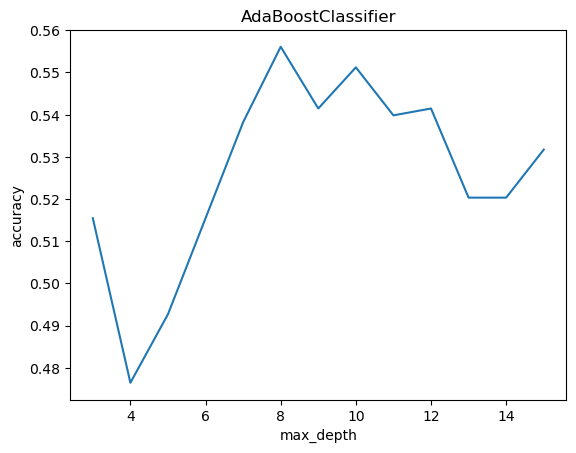

In [232]:

ada_acc = []
for i in depth_nums:

    ADA = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=i), n_estimators=100)
    ADA.fit(newsData.X_train[:, 1:], newsData.y_train)
    ada_pred = ADA.predict(newsData.X_test[:, 1:])
    ada_acc.append(accuracy_score(newsData.y_test, ada_pred))

fig, ax = plt.subplots()
ax.plot(depth_nums, ada_acc)
ax.set_xlabel('max_depth')
ax.set_ylabel('accuracy')
ax.set_title('AdaBoostClassifier')
plt.show()



In [241]:
DTC = DecisionTreeClassifier(max_depth= 3)
DTC.fit(newsData.X_train[:, 1:], newsData.y_train)
dtc_pred = DTC.predict(newsData.X_test[:, 1:])


RF = RandomForestClassifier(n_estimators=100, max_depth = 8)
RF.fit(newsData.X_train[:, 1:], newsData.y_train)
rf_pred = RF.predict(newsData.X_test[:, 1:])


ADA = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=8), n_estimators=100)
ADA.fit(newsData.X_train[:, 1:], newsData.y_train)
ada_pred = ADA.predict(newsData.X_test[:, 1:])

In [242]:
preds = []
preds.append(dtc_pred)
preds.append(rf_pred)
preds.append(ada_pred)


acc = []
f1 = []
r2 = []

for p in preds:
    acc.append(accuracy_score(newsData.y_test, p))
    f1.append(f1_score(newsData.y_test, p, average='micro'))
    r2.append(r2_score(newsData.y_test, p))

print(acc)
print(f1)
print(r2)

[0.6032520325203252, 0.6178861788617886, 0.5463414634146342]
[0.6032520325203252, 0.6178861788617886, 0.5463414634146342]
[-0.5776032966831255, -0.5098707758952989, -0.6679133244002275]
